In [4]:
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import re, collections
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import cohen_kappa_score

dataframe = pd.read_csv('training_set_rel3.tsv', encoding = 'latin-1',sep='\t')
dataframe = dataframe[['essay_id','essay_set','essay','domain1_score']]
dataframe.head()
dataframe.query('essay_set==4').domain1_score.unique()

array([0, 3, 2, 1], dtype=int64)

In [5]:
def normalScore(essay):
    normal = []
    for index,row in essay.iterrows():
        essay_set = row['essay_set']
        score = row['domain1_score']
        if essay_set==1:
            normal.append(score//7)
        if essay_set==2:
            normal.append(score//4)
        if essay_set==3:
            normal.append(score//2)
        if essay_set==4:
            normal.append(score//2)
        if essay_set==5:
            normal.append(score)
        if essay_set==6:
            normal.append(score)
        if essay_set==7:
            normal.append(score//13)
        if essay_set==8:
            normal.append(score//31)
    return essay.assign(normal_score=normal)
dataframe = normalScore(dataframe)
dataframe.head()
dataframe.normal_score.unique()

array([1, 0, 2, 3, 4], dtype=int64)

In [6]:
(dataframe.normal_score==1).sum()

6703

In [7]:
(dataframe.normal_score==0).sum()

3205

In [8]:
import enchant 
import pandas as pd
import spacy
import re
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
import urllib.request
from bs4 import BeautifulSoup
print("done")

done


In [9]:
nlp = spacy.load('en_core_web_md')

essays = dataframe

# ----------- Isolate essays from the 6th set ------------ #
essays = essays[(essays['essay_set'] == 6)]
essays.dropna(axis=1, how='all', inplace=True)

# load the enchant dictionary
d = enchant.Dict("en_US")

def getCorrectAndIncorrectSpelling(seriesOfEssays):
    """
    Returns a list of tuples:
    number of mispelled words, number of correctly spelled words 
    """
    _byRow = []

    for essay in seriesOfEssays:
        _individual = []
        for word in essay.split():

            _individual.append(d.check(word))

        _byRow.append((_individual.count(False), _individual.count(True)))

    return _byRow

# ------ Use Enchant to get the number of misspelt and correctly spelt words ------ #
spellings = getCorrectAndIncorrectSpelling(essays['essay'])

# create a list from the tuples
list1, list2 = zip(*spellings)

# assign them to the dataframe
essays = essays.assign(misspelt = list1) 
essays = essays.assign(correct = list2) 
essays.head()



C:\Users\user\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,essay_id,essay_set,essay,domain1_score,normal_score,misspelt,correct
8884,14834,6,There were many obstacles that the builders fa...,2,2,6,116
8885,14835,6,"Him from the start, there would have been many...",3,3,11,169
8886,14836,6,The builders of the Empire State Building face...,4,4,3,163
8887,14837,6,In the passage The Mooring Mast by Marcia Amid...,1,1,18,175
8888,14838,6,The builders of the Empire State Building face...,3,3,4,158


In [10]:
tokenizer = RegexpTokenizer(r'\w+')

# Number of words in essay
def get_essay_lengths(regExTokenizer, df):
    """
    Function that gets the number of words in an
    essay, not including punctuation and assigns them to the df
    """
    length = []
    for essay in df['essay']:
        length.append(len(regExTokenizer.tokenize(essay)))
        
    return df.assign(length = length) 

essays = get_essay_lengths(tokenizer, essays)   

# lexical diversity
def get_lexical_diversity(regExTokenizer, df):
    """
    Function that measures lexical diversity which is
    The ratio of total words to unique words
    Then assign that to the df
    """
    ld = []
    for essay in df['essay']:
        
        ld.append(round(len(regExTokenizer.tokenize(essay)) / float(len(set(regExTokenizer.tokenize(essay)))), 2))
    return df.assign(lexical_diversity = ld)

essays = get_lexical_diversity(tokenizer, essays)

# number of sentences
def get_number_of_sentences(df):
    """
    Function that returns the number of sentences
    in the document. Could be useful for run-on sentences
    Assign them to the df
    """
    
    _byRow_sents = []
    for essay in df['essay']:
        sents = []
        parsed_essay = nlp(essay)
        for num, sentence in enumerate(parsed_essay.sents):
            sents.append(sentence)
        
        _byRow_sents.append(len(sents))
        
    return df.assign(n_sentences = _byRow_sents)

essays = get_number_of_sentences(essays)

# Get Parts of Speech
def get_list_of_number_of_pos(df):
    """
    Function that parses the essay for each words POS
    Returns tuples containg for now, nouns, verbs, adverbs and adjectives
    """
    pos = []
    
    for essay in df['essay']:
        parsed_essay = nlp(essay)
        token_pos = [token.pos_ for token in parsed_essay]
        
        pos.append((token_pos.count('NOUN'), token_pos.count('VERB'), token_pos.count('ADV'), token_pos.count('ADJ')))
        
    return pos

pos_list = get_list_of_number_of_pos(essays)
nouns, verbs, adverbs, adjectives = zip(*pos_list)

# Assign them to the dataframe
essays = essays.assign(nouns = nouns)
essays = essays.assign(verbs = verbs)
essays = essays.assign(adverbs = adverbs)
essays = essays.assign(adjectives = adjectives)


# -------- Use Beautiful Soup to scrape for the top 500 SAT words ------- #
maxdf = essays[essays.domain1_score == essays.domain1_score.max()].iloc[0]
from rake_nltk import Rake
r = Rake(max_length=1) # Uses stopwords for english from NLTK, and all puntuation characters.
r.extract_keywords_from_text(maxdf.essay)
ini = r.get_ranked_phrases()
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
fin = set()
for word in ini:
    syns = wordnet.synsets(lemmatizer.lemmatize(word))
    if len(syns) != 0:
        syn = syns[0]
        lemmas = syn.lemmas()
        for lemma in lemmas:
            fin.add(lemma.name())
def wordnettopic(df):
    col = []
    for essay in df['essay']:
        r.extract_keywords_from_text(essay)
        ini = r.get_ranked_phrases()
        tot = 0
        for word in ini:
            if lemmatizer.lemmatize(word) in fin:
                tot+=1
        col.append(tot)
    return df.assign(wordnetscore = col)
essays = wordnettopic(essays)



,essay_id,essay_set,essay,domain1_score,normal_score,misspelt,correct,length,lexical_diversity,n_sentences,nouns,verbs,adverbs,adjectives,wordnetscore,n_top500
8884,14834,6,There were many obstacles that the builders fa...,2,2,6,116,123,1.37,9,28,14,8,10,3,0
8885,14835,6,"Him from the start, there would have been many...",3,3,11,169,180,1.55,10,41,23,12,14,6,0
8886,14836,6,The builders of the Empire State Building face...,4,4,3,163,169,1.62,9,39,23,10,9,24,0
8887,14837,6,In the passage The Mooring Mast by Marcia Amid...,1,1,18,175,199,1.69,11,35,26,7,4,4,0
8888,14838,6,The builders of the Empire State Building face...,3,3,4,158,162,1.74,11,35,26,8,15,8,0


In [12]:
essays.tail()
essays['n_sentences'].corr(essays['domain1_score'])

0.5620257492261873

In [21]:
essays.set_index('essay_id',inplace=True, drop=True)
X = essays.drop(['domain1_score','essay','essay_set','normal_score','n_top500'], axis=1)
y = essays['normal_score']
X.head()

,misspelt,correct,length,lexical_diversity,n_sentences,nouns,verbs,adverbs,adjectives,wordnetscore
essay_id,,,,,,,,,,
14834,6,116,123,1.37,9,28,14,8,10,3
14835,11,169,180,1.55,10,41,23,12,14,6
14836,3,163,169,1.62,9,39,23,10,9,24
14837,18,175,199,1.69,11,35,26,7,4,4
14838,4,158,162,1.74,11,35,26,8,15,8


In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import cohen_kappa_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1)

# Fit dt_entropy to the training set
dt_entropy.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_entropy.predict(X_test)

# Evaluate accuracy_entropy
accuracy_entropy = cohen_kappa_score(y_pred, y_test)
accuracy_entropy

0.3876073238853832

In [24]:
dt_gini = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1)

# Fit dt_entropy to the training set
dt_gini.fit(X_train, y_train)

# Use dt_entropy to predict test set labels
y_pred= dt_gini.predict(X_test)

# Evaluate accuracy_entropy
accuracy_gini = cohen_kappa_score(y_pred, y_test)
accuracy_gini

0.429310766863657

In [25]:
from sklearn.model_selection import cross_val_score
dt_entropy = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=2)

# split data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=25)

# Compute the array containing the 10-folds CV MSEs
Accuracy_CV_scores = cross_val_score(dt_entropy, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1) 

Accuracy_CV_scores

array([0.59722222, 0.58680556, 0.58680556, 0.58680556, 0.56597222])

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.ensemble import VotingClassifier

# Set seed for reproducibility
SEED=3

# Instantiate lr
lr = LogisticRegression(random_state=SEED)

# Instantiate knn
knn = KNN(n_neighbors=5)

# Instantiate dt
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=SEED)


# Define the list classifiers
classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn), ('Classification Tree', dt)]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=26)

# Iterate over the pre-defined list of classifiers
for clf_name, clf in classifiers:    
 
    # Fit clf to the training set
    clf.fit(X_train, y_train)    
   
    # Predict y_pred
    y_pred = clf.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_pred, y_test) 
   
    # Evaluate clf's accuracy on the test set
    print('{:s} : {:.3f}'.format(clf_name, accuracy))

Logistic Regression : 0.515
K Nearest Neighbours : 0.594
Classification Tree : 0.612


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [67]:
vc = VotingClassifier(estimators=classifiers)     

# Fit vc to the training set
vc.fit(X_train, y_train)   

# Evaluate the test set predictions
y_pred = vc.predict(X_test)

# Calculate accuracy score
accuracy = accuracy_score(y_pred, y_test)
print('Voting Classifier: {:.3f}'.format(accuracy))

Voting Classifier: 0.614


C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [68]:
from sklearn.ensemble import BaggingClassifier

# split data set into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)

# Instantiate dt
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=0.016, random_state=4)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=50, random_state=12)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_pred, y_test)
print('Test set accuracy of bc: {:.2f}'.format(acc_test))

Test set accuracy of bc: 0.61


In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=33)

# Instantiate dt
dt = DecisionTreeClassifier(criterion='gini', max_depth=4, min_samples_leaf=0.016, random_state=4)

# Instantiate bc
bc = BaggingClassifier(base_estimator=dt, n_estimators=300, oob_score=True, n_jobs=-1, random_state=13)

# Fit bc to the training set
bc.fit(X_train, y_train)

# Predict test set labels
y_pred = bc.predict(X_test)

# Evaluate acc_test
acc_test = accuracy_score(y_pred, y_test)

# Extract the OOB accuracy from bc
oob_accuracy = bc.oob_score_

print('Test set accuracy of bc: {:.2f}'.format(acc_test)) 

print('OOB accuracy of bc: {:.2f}'.format(oob_accuracy))

Test set accuracy of bc: 0.61
OOB accuracy of bc: 0.60


In [69]:
from sklearn.ensemble import RandomForestClassifier

# Instantiate rf
rf = RandomForestClassifier(criterion='gini', random_state=2)
            
# Fit rf to the training set    
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=2)

In [70]:
rf.get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2,
 'verbose': 0,
 'warm_start': False}

In [71]:
from sklearn.model_selection import RandomizedSearchCV

# criterion for information gain
criterion = ['gini', 'entropy']

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'criterion': criterion,
               'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'criterion': ['gini', 'entropy'],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [49]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  6.6min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [50]:
rf_random.best_params_


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': None,
 'criterion': 'entropy',
 'bootstrap': True}

In [51]:
from sklearn.metrics import classification_report, confusion_matrix

rf_random = RandomForestClassifier(criterion='entropy', 
                            n_estimators=1000, 
                            min_samples_leaf=4, 
                            min_samples_split=2, 
                            max_features='auto',
                            max_depth=None,
                            bootstrap=True,
                            random_state=2)

# Fit rf to the training set    
rf_random.fit(X_train, y_train)

# predict
y_pred = rf_random.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))
print('\n')

=== Confusion Matrix ===
[[  2   0   0   2   0]
 [  2   5  26   2   0]
 [  0   1  34  37   1]
 [  0   0  18 128  25]
 [  0   0   0  34  43]]


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         4
           1       0.83      0.14      0.24        35
           2       0.44      0.47      0.45        73
           3       0.63      0.75      0.68       171
           4       0.62      0.56      0.59        77

    accuracy                           0.59       360
   macro avg       0.60      0.48      0.49       360
weighted avg       0.61      0.59      0.57       360





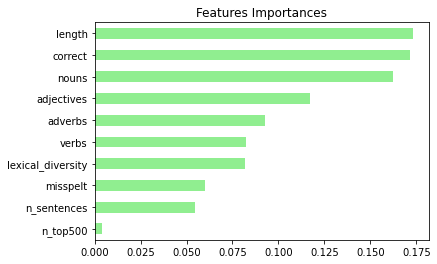

In [56]:
importances = pd.Series(data=rf_random.feature_importances_, index= X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

KeyError: 1